In [1]:
import numpy as np
from IPython.display import *
%pylab inline
import matplotlib.pyplot as plt
import time

Populating the interactive namespace from numpy and matplotlib


In [58]:
E_rel = 1e-2
E_abs = 1e-2

In [59]:
def eps(y_n, y_n1, h):
    return E_abs + E_rel*(y_n + y_n1)/2.

In [60]:
def err(y_n, y_n1, yd_n1, h):
    d = y_n.size
    v = (y_n1 - yd_n1)/eps(y_n, y_n1, h)
    return np.sqrt((v*v).sum() / d)

In [61]:
factor_min = 1e-2
factor_max = 1e1
factor = 0.9
h_min = 1e-6

In [80]:
def h_opt(q, err_h, h):
    return max(h_min,
               h*min(factor_max,
                     max(factor_min,
                         factor*np.power(1./err_h, 1./(q+1)))))

In [81]:
def norm(y0, y):
    eps_0 = E_abs + np.abs(y0)*E_rel
    v = y/eps_0
    d = y.size
    return np.sqrt((v*v).sum()/d)

In [82]:
def starting_h(p, f, x0, y0):
    d0 = norm(y0, y0)
    d1 = norm(x0, y0)
    h0 = 0.01 * d0/d1
    v0 = f(x0, y0)
    y1 = y0 + h0*v0
    v1 = f(x0+h0, y1)
    d2 = norm(y0, v1 - v0) / h0
    d_max = max(d1,d2)
    h1 = np.power(0.01/d_max, 1/(p+1))
    if d_max < 1e-15:
        h1 = max(1e-6, h0 * 1e-3)
    return min(100*h0, h1)

In [91]:
class ArrayMethod:
    def __init__(self, Arr_Y, Arr_X, p):
        width = len(Arr_X[-1])
        self.Arr_X = np.array([x + [0] * (width - len(x)) for x in Arr_X], 
                              dtype=float)
        self.Arr_Y = np.array(Arr_Y, dtype=float)
        self.p = p
        
    def method(self, g, G0, X0, XF, max_iter = 1e6):
        h = starting_h(self.p, g, X0, G0)
        Ys = [G0]
        Xs = [X0]
        while Xs[-1] < XF and max_iter > 0:
            max_iter -= 1
            if max_iter % 1e4 == 0:
                print('.', end="",flush=True)
            K = np.zeros(self.Arr_X[-1].shape + (2,))
            K[0] = h*g(Xs[-1], Ys[-1])
            for ind in range(len(self.Arr_Y)):
                h_param = self.Arr_Y[ind]
                y_params = self.Arr_X[ind]
                y = (K.T * y_params).sum(1) + Ys[-1]
                k = h*g(Xs[-1] + h*h_param, y)
                K[ind+1] = k
            Ys.append(Ys[-1] + \
                (self.Arr_X[-2] * K.T).sum(1))
            yd = Ys[-1] + \
                (self.Arr_X[-1] * K.T).sum(1)
            e = err(Ys[-2], Ys[-1], yd, h)
            h = h_opt(self.p, e, h)
            Xs.append(Xs[-1] + h)
        print('|')
        return [Xs, array(Ys).T]

In [92]:
MERSON_Y = [1/3., 1/3., 1/2., 1.]
MERSON_X = [
    [1/3.],
    [1/6., 1/6.],
    [1/8, 0., 3/8.],
    [1/2., 0., -3/2., 2.],
    [1/6., 0., 0., 2/3., 1/6.],
    [1/10., 0., 3/10., 2/5., 1/5.]
]

In [93]:
R38_Y = [1/3., 2/3., 1]
R38_X = [
    [1/3.],
    [-1/3., 1.],
    [1., -1., 1.],
    [1/8., 3/8., 3/8., 1/8.],
    [1/12., 1/2., 1/4., 0., 1/6.]
]

In [106]:
VERNER_Y = [1/6., 4/15., 2/3., 5/6., 1., 1/15., 1.]
VERNER_X = [
    [1/6.],
    [4/75., 16/75.],
    [5/6., -8/3., 5/2.],
    [-165/64., 55/6., -425/64., 85/96.],
    [12/5., -8., 4015/612., -11/36., 88/255.],
    [-8263/15000., 124/75., -643/680., -81/250., 2484/10625., 0],
    [3501/1720., -300/43., 297275/52632., -319/2322., 24068/84065., 0., 3850/26703.],
    [3/40., 0., 875/2244., 23/72., 264/1955., 0., 125/11792., 43/616.],
    [13/160., 0., 2375/5984., 5/16., 12/85., 3/44., 0., 0.]
]

In [94]:
X0 = 0
F0 = array([1, 0])
XF = 10

g = 10.
l = 5.

def f(t, Ys):
    y, v = Ys
    return np.array([-v*g/l, y])

def F(y, F0 = F0):
    return F0[0]*np.cos(y*np.power(g/l, 1/2))

In [149]:
def plot_results_for(method):
    x, ys = method(f, F0, X0, XF)
    y = ys[1]
    TS = F(x)
    err = np.log10(np.absolute(np.powerx(y - TS, 2)/TS))
    _, plots = plt.subplots(2, sharex=True)
    p1, p2 = plots
    p1.plot(x, err)
    h = np.log10(array(x[1:]) - x[:-1])
    p2.plot(x[1:], h)
    return x, y

|


/usr/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


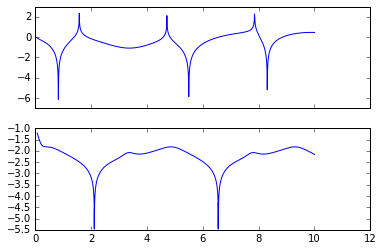

In [150]:
plot_results_for(ArrayMethod(R38_Y, R38_X, 3).method);

|


/usr/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


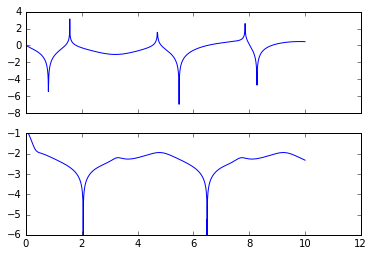

In [151]:
plot_results_for(ArrayMethod(MERSON_Y, MERSON_X, 4).method);

|


/usr/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


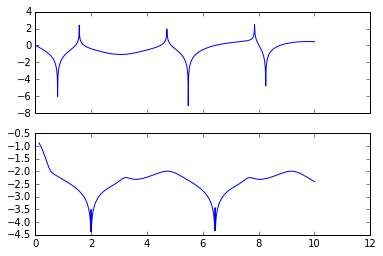

In [155]:
plot_results_for(ArrayMethod(VERNER_Y, VERNER_X, 5).method);

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


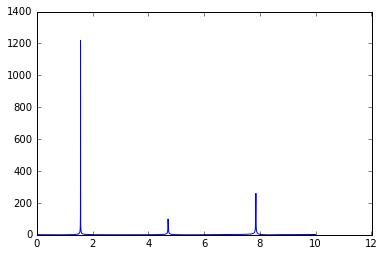

In [108]:
plot(x, np.abs((y[1] - F(x))/F(x)))